<a href="https://colab.research.google.com/github/greentfrapp/lucent/blob/master/notebooks/neuron_interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neuron Interactions

This notebook combines the [`neuron_interaction`](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/neuron_interaction.ipynb) and [`negative_neuron`](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/negative_neurons.ipynb) notebooks from Lucid.

## Install, Import, Load Model

In [2]:
!pip install --quiet git+https://github.com/greentfrapp/lucent.git

!wget -qnc https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth

     |████████████████████████████████| 163kB 5.1MB/s 


In [0]:
import torch

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True, modelpath="inception5h.pth")
_ = model.to(device).eval()

## Negative Channel Visualizations

Just like in Lucid, we can generate visualizations that maximize activations in both the positive and negative directions.

100%|██████████| 512/512 [00:20<00:00, 24.52it/s]



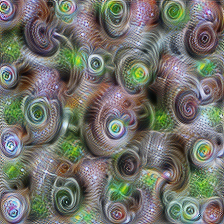
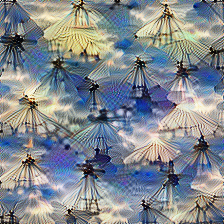

In [5]:
param_f = lambda: param.image(224, batch=2)
obj = objectives.channel("mixed4a", 492, batch=1) - objectives.channel("mixed4a", 492, batch=0)
_ = render.render_vis(model, obj, param_f, show_inline=True)

100%|██████████| 512/512 [00:20<00:00, 24.81it/s]



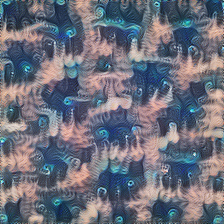
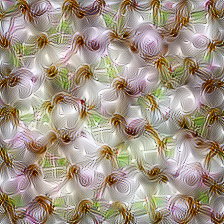

In [6]:
# Dark and light
obj = objectives.channel("mixed4a", 104, batch=1) - objectives.channel("mixed4a", 104, batch=0)
_ = render.render_vis(model, obj, param_f, show_inline=True)

100%|██████████| 512/512 [00:22<00:00, 23.15it/s]



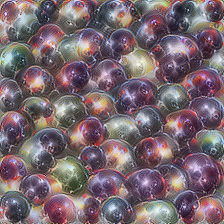
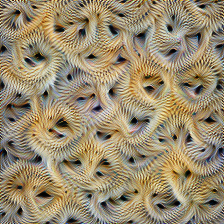

In [7]:
# Galaxy balls and wyrm husks
obj = objectives.channel("mixed4b", 154, batch=1) - objectives.channel("mixed4b", 154, batch=0)
_ = render.render_vis(model, obj, param_f, show_inline=True)

## Combining Neurons

As shown in the [tutorial](https://colab.research.google.com/github/greentfrapp/lucent/blob/master/notebooks/tutorial.ipynb), we can also combine objectives and the resulting visualizations form an intuitive amalgam of the inputs.

The corresponding Lucid [notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/feature-visualization/neuron_interaction.ipynb) already has a set of nice channels for combining.

In [0]:
neuron1 = ('mixed4b', 111)     # large fluffy
# neuron1 = ('mixed3a', 139)   # pointilist
# neuron1 = ('mixed3b',  81)   # brush trokes
# neuron1 = ('mixed4a',  97)   # wavy
# neuron1 = ('mixed4a',  41)   # frames
# neuron1 = ('mixed4a', 479)   # B/W

neuron2 = ('mixed4a', 476)     # art
# neuron2 = ('mixed4b', 360)   # lattices
# neuron2 = ('mixed4b', 482)   # arcs
# neuron2 = ('mixed4c', 440)   # small fluffy
# neuron2 = ('mixed4d', 479)   # bird beaks
# neuron2 = ('mixed4e', 718)   # shoulders

100%|██████████| 512/512 [00:22<00:00, 22.36it/s]



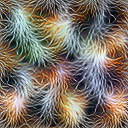
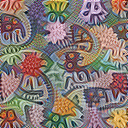
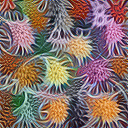

In [9]:
param_f = lambda: param.image(128, batch=3)

# First image optimizes neuron1
# Second image optimizes neuron2
# Third image optimizes sum of both
C = lambda neuron1, neuron2: objectives.channel(*neuron1, batch=0) + \
  objectives.channel(*neuron2, batch=1) + \
  objectives.channel(*neuron1, batch=2) + \
  objectives.channel(*neuron2, batch=2)

_ = render.render_vis(model, C(neuron1, neuron2), param_f, show_inline=True)

Uncomment the code and try it out for yourself!

## Aligned Interpolation

The authors of the Feature Visualization [article](https://distill.pub/2017/feature-visualization/) also invented a neat way to interpolate between objectives that encouraged spatial coherence.

In essence, we have a batch of images that all share a set of interpolated source tensors, which helps to encourage alignment. For more details, check out the relevant scripts in Lucid ([lowres.py](https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/lowres.py), [objectives.py](https://github.com/tensorflow/lucid/blob/0bc33f0c737fc7428343f6c778c478fe9c0dd2b0/lucid/optvis/objectives.py#L300)) and Lucent ([lowres.py](https://github.com/greentfrapp/lucent/blob/master/lucent/optvis/param/lowres.py), [objectives.py](https://github.com/greentfrapp/lucent/blob/01c3267eef2a9c8d0c83732efe9eb9694778c879/lucent/optvis/objectives.py#L127)).

100%|██████████| 512/512 [00:32<00:00, 15.88it/s]



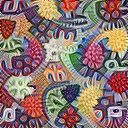
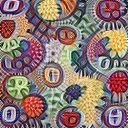
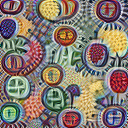
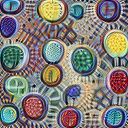
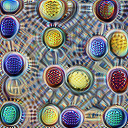
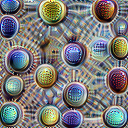

In [10]:
def interpolate_param_f():
  # We start with a batch of FFT parameterized images
  params, image_f = param.fft_image((6, 3, 128, 128))
  # We then add a bunch of low-res interpolated tensors
  shared = [
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//2, 128//2)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//4, 128//4)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//8, 128//8)),
      param.lowres_tensor((6, 3, 128, 128), (1, 3, 128//16, 128//16)),
      param.lowres_tensor((6, 3, 128, 128), (2, 3, 128//16, 128//16)),
  ]
  # Accumulate the params and outputs
  images = []
  for (p, i) in shared:
      params += p
      images.append(i)
  return params, param.to_valid_rgb(lambda: image_f() + sum([i() for i in images]), decorrelate=True)

# This objective function adjusts relative proportions of the two objectives
# gradually from the first image to the last
obj = objectives.channel_interpolate("mixed4a", 476, "mixed4a", 465)

_ = render.render_vis(model, obj, interpolate_param_f, show_inline=True)

More examples from the Feature Visualization [paper](https://distill.pub/2017/feature-visualization/#interaction).

100%|██████████| 512/512 [00:32<00:00, 15.90it/s]



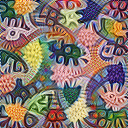
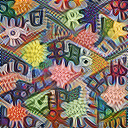
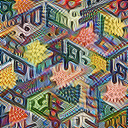
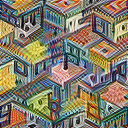
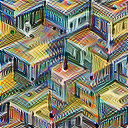
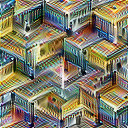

In [11]:
obj = objectives.channel_interpolate("mixed4a", 476, "mixed4a", 455)

_ = render.render_vis(model, obj, interpolate_param_f, show_inline=True)

100%|██████████| 512/512 [00:32<00:00, 15.91it/s]



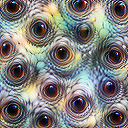
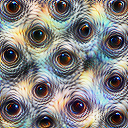
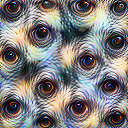
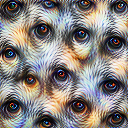
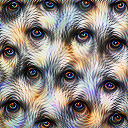
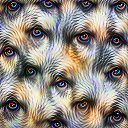

In [12]:
obj = objectives.channel_interpolate("mixed4a", 460, "mixed4a", 501)

_ = render.render_vis(model, obj, interpolate_param_f, show_inline=True)